In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay,classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import joblib

In [5]:
df = pd.read_csv('data.csv')

In [6]:
df.head()

,x1,y1,z1,x2,y2,z2,x3,y3,z3,x4,...,x19,y19,z19,x20,y20,z20,x21,y21,z21,label
0,262.669968,257.304901,-3.649205e-07,257.417542,247.109055,0.004224,246.882957,241.716827,0.005798,236.384537,...,223.345093,255.490692,-0.020450,215.043365,258.114746,-0.024577,208.006393,259.608673,-0.026722,call
1,83.351778,346.059113,-2.345265e-07,81.925037,328.562347,-0.011102,90.080132,311.535248,-0.021096,95.641823,...,132.451618,341.794434,-0.038175,142.773582,342.829254,-0.037336,152.431698,343.015991,-0.036136,call
2,187.756977,260.235492,-2.417307e-07,195.460579,241.506035,-0.000184,207.259529,223.674339,-0.009687,215.413628,...,250.301010,268.602938,-0.044068,262.425133,271.276638,-0.040469,272.989952,272.272231,-0.038301,call
3,114.976696,331.594238,-1.233261e-07,114.503494,320.549957,-0.002824,116.636627,310.080994,-0.008911,117.685066,...,145.195450,329.357544,-0.027622,151.053200,329.712341,-0.027863,155.990364,329.548828,-0.027723,call
4,188.795288,141.727867,-1.622995e-07,188.520905,127.947464,-0.002884,191.982880,111.010563,-0.008115,192.552521,...,226.696396,132.263248,-0.025113,234.831741,130.684147,-0.024087,241.587769,128.477188,-0.023486,call


In [7]:
df.shape

(25675, 64)

In [8]:
df['label'].unique()

array(['call', 'dislike', 'fist', 'four', 'like', 'mute', 'ok', 'one',
       'palm', 'peace', 'peace_inverted', 'rock', 'stop', 'stop_inverted',
       'three', 'three2', 'two_up', 'two_up_inverted'], dtype=object)

In [9]:
X=df.drop('label', axis=1)
y=df['label']

### Insight: This section inspects the first few rows of the data (df.head()) and determines the dataset size to be 25,675 rows and 64 columns (df.shape), It identifies the unique gesture classes present in the label column, such as 'call', 'dislike', 'fist', 'palm', and others.

### Action: The data is split into features (X) and the target label (y).

# Data Visualization

In [10]:
X_arr = X.values
y_arr = y.values

classes   = np.unique(y_arr)
n_classes = len(classes)
colors    = plt.cm.tab20(np.linspace(0, 1, n_classes))
color_map = {cls: colors[i] for i, cls in enumerate(classes)}

HAND_CONNECTIONS = [
    (0,1),(1,2),(2,3),(3,4),
    (0,5),(5,6),(6,7),(7,8),
    (0,9),(9,10),(10,11),(11,12),
    (0,13),(13,14),(14,15),(15,16),
    (0,17),(17,18),(18,19),(19,20),
    (5,9),(9,13),(13,17)
]

def extract_xy(row):
    """row is a 1D numpy array of 63 values: x0,y0,z0, x1,y1,z1, ..."""
    x_coords = [row[i * 3]     for i in range(21)]
    y_coords = [row[i * 3 + 1] for i in range(21)]
    return np.array(x_coords), np.array(y_coords)

def draw_hand(ax, x_coords, y_coords, color, title):
    for start, end in HAND_CONNECTIONS:
        ax.plot([x_coords[start], x_coords[end]],
                [y_coords[start], y_coords[end]],
                color=color, linewidth=1.8, alpha=0.7)
    ax.scatter(x_coords, y_coords, color=color, s=45, zorder=5)
    for i, (xi, yi) in enumerate(zip(x_coords, y_coords)):
        ax.annotate(str(i), (xi, yi), fontsize=5,
                    ha='center', va='bottom', color='black')
    ax.set_title(title, fontsize=10, fontweight='bold')
    ax.invert_yaxis()
    ax.set_aspect('equal')
    ax.axis('off')

Plot (1):
A random sample from each class is plotted to visually compare representative observations across clusters.

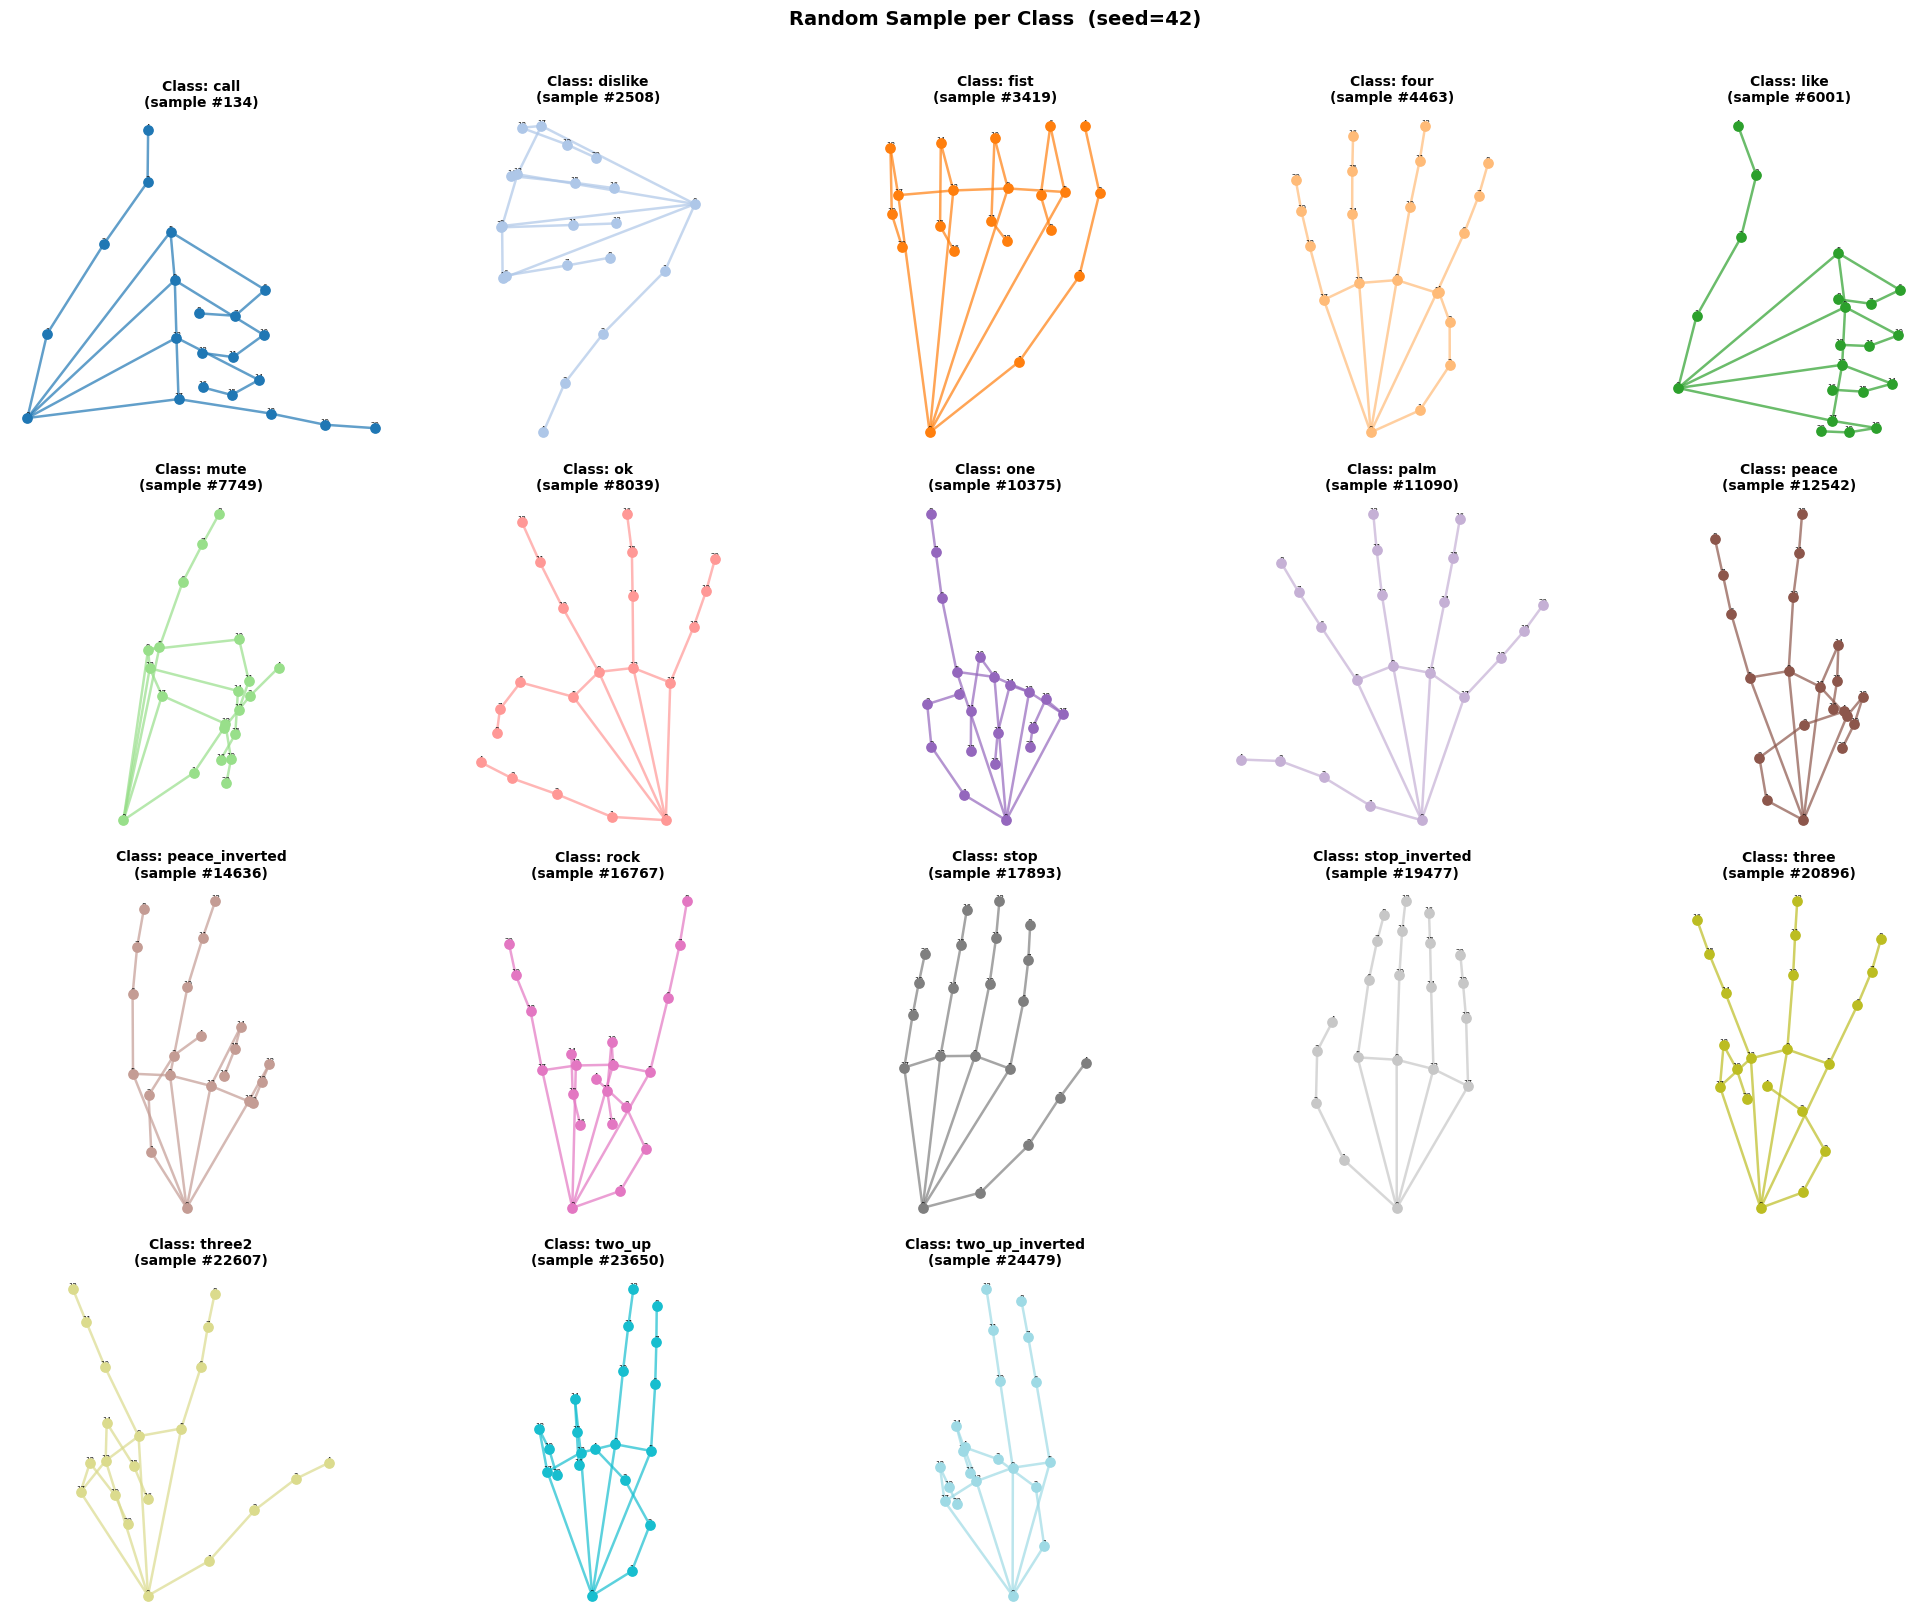

In [11]:
rng = np.random.default_rng(seed=42)
n_cols = 5
n_rows = int(np.ceil(n_classes / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 4, n_rows * 4))
axes = axes.flatten()

for i, cls in enumerate(classes):
    mask = np.where(y_arr == cls)[0]
    idx = rng.choice(mask)
    row = X_arr[idx]
    xc, yc = extract_xy(row)
    draw_hand(axes[i], xc, yc, color=color_map[cls], title=f'Class: {cls}\n(sample #{idx})')

for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

plt.suptitle('Random Sample per Class  (seed=42)', fontsize=14, fontweight='bold', y=1.01)
plt.tight_layout()
plt.show()

### Insight: This section defines a color map for the classes and a set of HAND_CONNECTIONS to visualize the structure of the hand landmarks and the extract_xy function converts the row data into x and y coordinates, and draw_hand plots these coordinates, labeling each landmark point from 0 to 20

### A random sample from each class is visually compared

Plot (2):
The number of samples per class and the mean class size are calculated, and a pie chart is plotted to show the percentage distribution of each class in the dataset.

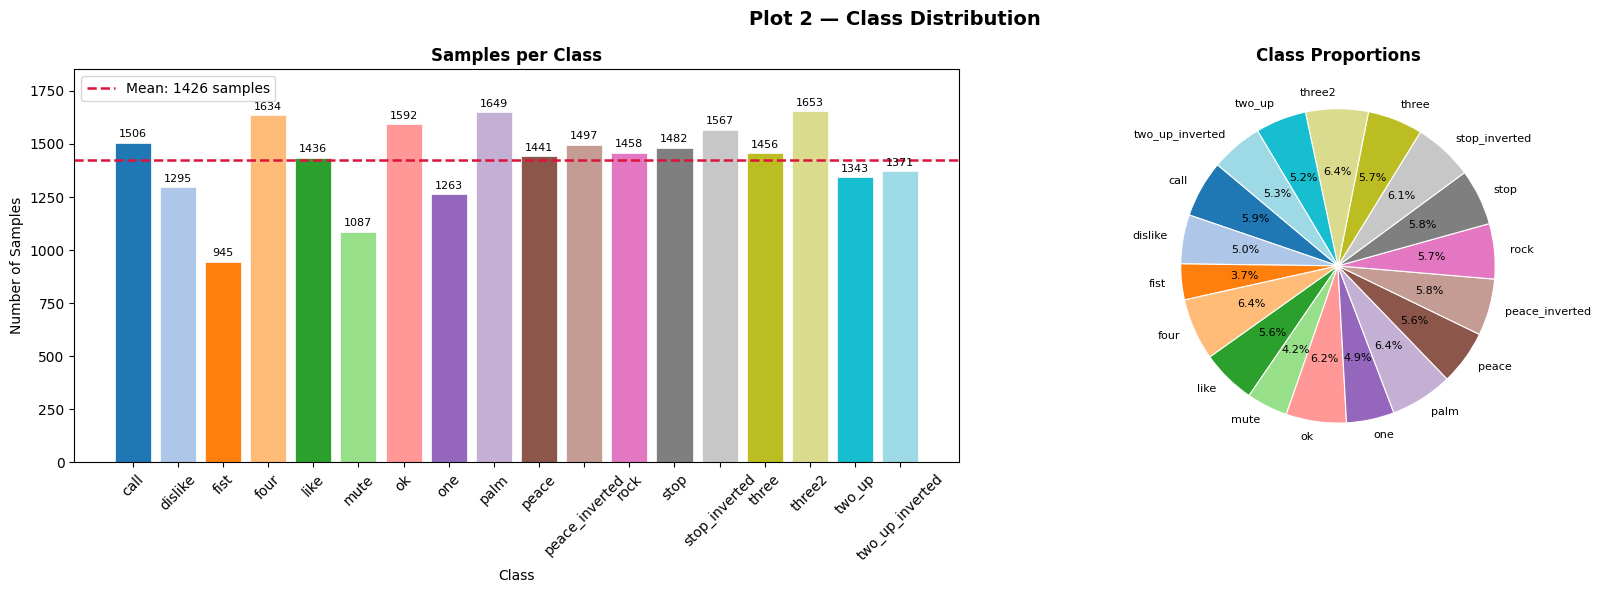

Total samples  : 25675
Mean per class : 1426
Max            : 1653 [three2]
Min            : 945 [fist]
Imbalance ratio: 1.75x


In [12]:
counts = pd.Series(y).value_counts().sort_index()
mean_count = counts.mean()

fig, axes = plt.subplots(1, 2, figsize=(18, 6))

bar_colors = [color_map[c] for c in counts.index]
bars = axes[0].bar(counts.index, counts.values, color=bar_colors, edgecolor='white', linewidth=0.5)

for bar, count in zip(bars, counts.values):
    axes[0].text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height() + max(counts) * 0.01,
        str(count), ha='center', va='bottom', fontsize=8
    )

axes[0].axhline(mean_count, color='crimson', linestyle='--', linewidth=1.8, label=f'Mean: {mean_count:.0f} samples')
axes[0].set_title('Samples per Class', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Class')
axes[0].set_ylabel('Number of Samples')
axes[0].tick_params(axis='x', rotation=45)
axes[0].legend(fontsize=10)
axes[0].set_ylim(0, counts.max() * 1.12)

axes[1].pie(
    counts.values,
    labels=counts.index,
    autopct='%1.1f%%',
    colors=bar_colors,
    startangle=140,
    textprops={'fontsize': 8},
    wedgeprops={'edgecolor': 'white', 'linewidth': 0.8}
)
axes[1].set_title('Class Proportions', fontsize=12, fontweight='bold')

plt.suptitle('Plot 2 — Class Distribution', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print(f'Total samples  : {len(y)}')
print(f'Mean per class : {mean_count:.0f}')
print(f'Max            : {counts.max()} [{counts.idxmax()}]')
print(f'Min            : {counts.min()} [{counts.idxmin()}]')
print(f'Imbalance ratio: {counts.max()/counts.min():.2f}x')

Plot (3):
Outliers are identified for each class, their percentage within each class is computed, and the total number of outliers across all classes is calculated

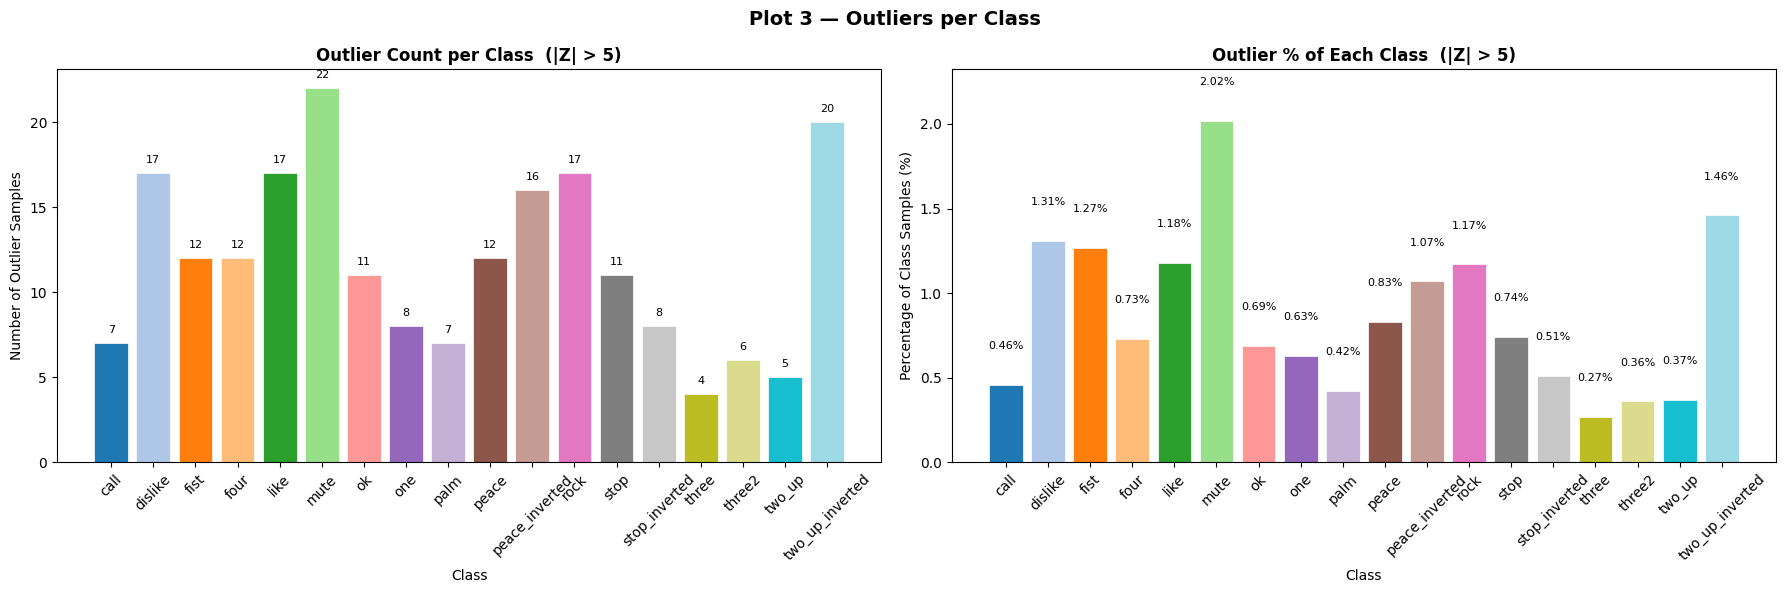

          Class  Total Samples  Outlier Count  Outlier %
           mute           1087             22       2.02
two_up_inverted           1371             20       1.46
        dislike           1295             17       1.31
           fist            945             12       1.27
           like           1436             17       1.18
           rock           1458             17       1.17
 peace_inverted           1497             16       1.07
          peace           1441             12       0.83
           stop           1482             11       0.74
           four           1634             12       0.73
             ok           1592             11       0.69
            one           1263              8       0.63
  stop_inverted           1567              8       0.51
           call           1506              7       0.46
           palm           1649              7       0.42
         two_up           1343              5       0.37
         three2           1653 

In [13]:
Z_THRESHOLD = 5
outlier_counts = {}
outlier_pcts   = {}

for cls in classes:
    mask      = y == cls
    X_cls     = X[mask]
    z_scores  = np.abs(stats.zscore(X_cls, axis=0))
    is_outlier            = (z_scores > Z_THRESHOLD).any(axis=1)
    outlier_counts[cls]   = int(is_outlier.sum())
    outlier_pcts[cls]     = round(100 * is_outlier.mean(), 2)

fig, axes = plt.subplots(1, 2, figsize=(18, 6))
bar_colors = [color_map[c] for c in classes]

bars1 = axes[0].bar(outlier_counts.keys(), outlier_counts.values(), color=bar_colors, edgecolor='white', linewidth=0.5)
for bar, val in zip(bars1, outlier_counts.values()):
    axes[0].text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height() + 0.5,
        str(val), ha='center', va='bottom', fontsize=8
    )
axes[0].set_title(f'Outlier Count per Class  (|Z| > {Z_THRESHOLD})', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Class')
axes[0].set_ylabel('Number of Outlier Samples')
axes[0].tick_params(axis='x', rotation=45)

bars2 = axes[1].bar(outlier_pcts.keys(), outlier_pcts.values(), color=bar_colors, edgecolor='white', linewidth=0.5)
for bar, val in zip(bars2, outlier_pcts.values()):
    axes[1].text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height() + 0.2,
        f'{val}%', ha='center', va='bottom', fontsize=8
    )
axes[1].set_title(f'Outlier % of Each Class  (|Z| > {Z_THRESHOLD})', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Class')
axes[1].set_ylabel('Percentage of Class Samples (%)')
axes[1].set_ylim(0, max(outlier_pcts.values()) * 1.15)
axes[1].tick_params(axis='x', rotation=45)

plt.suptitle('Plot 3 — Outliers per Class', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

summary = pd.DataFrame({
    'Class'          : list(outlier_counts.keys()),
    'Total Samples'  : [int((y == cls).sum()) for cls in classes],
    'Outlier Count'  : list(outlier_counts.values()),
    'Outlier %'      : list(outlier_pcts.values())
})
summary = summary.sort_values('Outlier %', ascending=False)
print(summary.to_string(index=False))
print(f'\nTotal outliers: {sum(outlier_counts.values())} '
      f'({100*sum(outlier_counts.values())/len(y):.1f}% of all data)')

# Preprocessing


1.   Subtract all point of x,y from x0,y0
2.   calculate norm of x12,y12 and divide all points of x,y on this norm




In [14]:
for axis in ['x', 'y']:
    base_col = f'{axis}1'
    cols = [f'{axis}{i}' for i in range(2, 22)]
    X[cols] = X[cols].sub(X[base_col], axis=0)

norm = np.sqrt(X['x13']**2 + X['y13']**2)
norm = norm.replace(0, np.nan)
X_col = [f'x{i}' for i in range(1, 22)]
y_col = [f'y{i}' for i in range(1, 22)]
X[X_col] = X[X_col].div(norm, axis=0)
X[y_col] = X[y_col].div(norm, axis=0)

# Data Splitting

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((20540, 63), (5135, 63), (20540,), (5135,))

# Learning Phase

### Insight: The notebook attempts to train several models: KNeighborsClassifier, SVC (SVM), RandomForestClassifier, and AdaBoostClassifier

## KNN Model

## Fitting Data

In [15]:
knn = KNeighborsClassifier(n_neighbors=11,weights='distance',metric='manhattan')
cv_scores = cross_val_score(knn,X_train,y_train,cv=3,scoring='f1_macro')
#Scores of cross validation
print("Cross Validation Scores:", cv_scores)

#mean score of the 3 folds = score of the knn model
print("Mean CV Score:", np.mean(cv_scores))

Cross Validation Scores: [0.93257987 0.93486805 0.9343769 ]
Mean CV Score: 0.9339416075647664


In [16]:
#fit model on whole data
knn.fit(X_train, y_train)

#predict the performane of the model
y_pred_knn = knn.predict(X_test)

#calculte f1 score on test split
f1 = f1_score(y_test, y_pred_knn,average='macro')
print("Test F1 Score:", f1)

Test F1 Score: 0.9438920079446296


In [17]:
# Save model to file
joblib.dump(knn, "KNN_model.pkl")

print("Model saved successfully!")

Model saved successfully!


## Metrics

In [18]:
acc = accuracy_score(y_test, y_pred_knn)
prec = precision_score(y_test, y_pred_knn, average='macro')
rec = recall_score(y_test, y_pred_knn, average='macro')
f1 = f1_score(y_test, y_pred_knn, average='macro')

print("\nknn Results:")
print(f"Accuracy  : {acc:.4f}")
print(f"Precision : {prec:.4f}")
print(f"Recall    : {rec:.4f}")
print(f"F1 Score  : {f1:.4f}")


knn Results:
Accuracy  : 0.9433
Precision : 0.9443
Recall    : 0.9439
F1 Score  : 0.9439


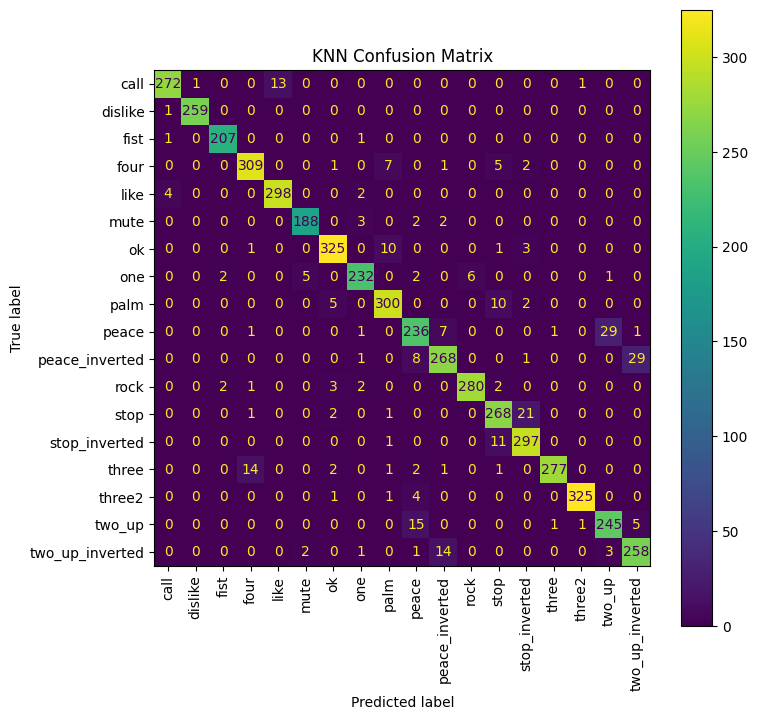

In [ ]:
cm_knn = confusion_matrix(y_test, y_pred_knn)
fig, ax = plt.subplots(figsize=(8,8))

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm_knn,
    display_labels=knn.classes_
)

disp.plot(ax=ax)

plt.xticks(rotation=90)

plt.title("KNN Confusion Matrix")
plt.show()

In [20]:
# Classification Report
report = classification_report(y_test, y_pred_knn)
print("Classification Report:\n", report)

Classification Report:
                  precision    recall  f1-score   support

           call       0.98      0.95      0.96       287
        dislike       1.00      1.00      1.00       260
           fist       0.98      0.99      0.99       209
           four       0.94      0.95      0.95       325
           like       0.96      0.98      0.97       304
           mute       0.96      0.96      0.96       195
             ok       0.96      0.96      0.96       340
            one       0.95      0.94      0.95       248
           palm       0.93      0.95      0.94       317
          peace       0.87      0.86      0.86       276
 peace_inverted       0.91      0.87      0.89       307
           rock       0.98      0.97      0.97       290
           stop       0.90      0.91      0.91       293
  stop_inverted       0.91      0.96      0.94       309
          three       0.99      0.93      0.96       298
         three2       0.99      0.98      0.99       331
      

## SVM Model

## Fitting Data

In [21]:
svm = SVC(C=130,gamma=0.05,kernel='rbf',random_state=42)
cv_scores = cross_val_score(svm,X_train,y_train,cv=3,scoring='f1_macro')

#Scores of cross validation
print("Cross Validation Scores:", cv_scores)

#mean score of the 3 folds = score of the svm model
print("Mean CV Score:", np.mean(cv_scores))


Cross Validation Scores: [0.97887224 0.97765707 0.97960568]
Mean CV Score: 0.9787116608654544


In [22]:
#fit model on whole data
svm.fit(X_train, y_train)

#predict the performane of the model
y_pred_svm = svm.predict(X_test)

#calculte f1 score on test split
f1 = f1_score(y_test, y_pred_svm,average='macro')
print("Test F1 Score:", f1)

Test F1 Score: 0.9780429943841233


In [23]:
# Save model to file
joblib.dump(svm, "svm_model.pkl")

print("Model saved successfully!")

Model saved successfully!


## Metrics

In [ ]:
acc = accuracy_score(y_test, y_pred_svm)
prec = precision_score(y_test, y_pred_svm, average='macro')
rec = recall_score(y_test, y_pred_svm, average='macro')
f1 = f1_score(y_test, y_pred_svm, average='macro')

print("\nsvm Results:")
print(f"Accuracy  : {acc:.4f}")
print(f"Precision : {prec:.4f}")
print(f"Recall    : {rec:.4f}")
print(f"F1 Score  : {f1:.4f}")


svm Results:
Accuracy  : 0.9786
Precision : 0.9781
Recall    : 0.9781
F1 Score  : 0.9780


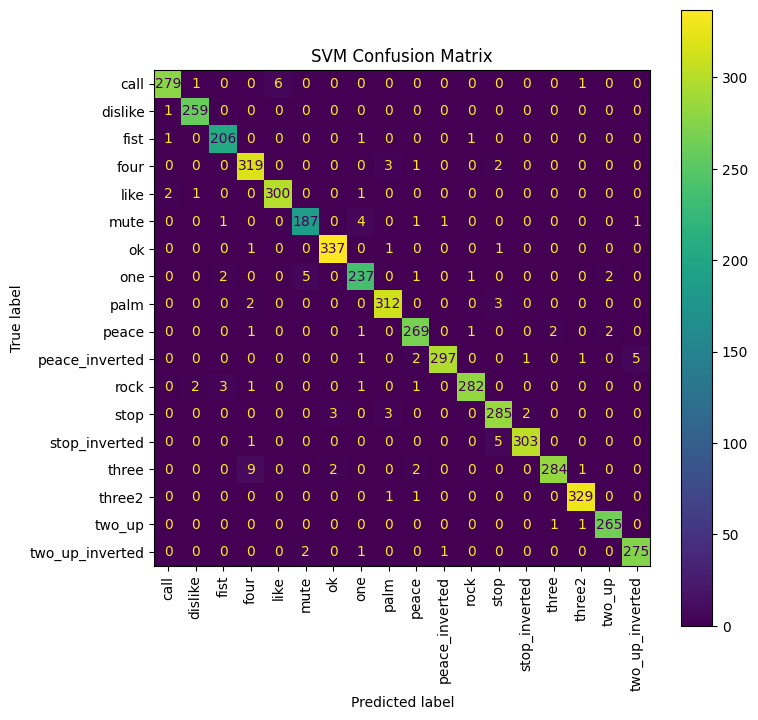

In [ ]:
cm_svm = confusion_matrix(y_test, y_pred_svm)
fig, ax = plt.subplots(figsize=(8,8))

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm_svm,
    display_labels=svm.classes_
)

disp.plot(ax=ax)

plt.xticks(rotation=90)

plt.title("SVM Confusion Matrix")
plt.show()

In [ ]:
# Classification Report
report = classification_report(y_test, y_pred_svm)

print("Classification Report:\n", report)

Classification Report:
                  precision    recall  f1-score   support

           call       0.99      0.97      0.98       287
        dislike       0.98      1.00      0.99       260
           fist       0.97      0.99      0.98       209
           four       0.96      0.98      0.97       325
           like       0.98      0.99      0.98       304
           mute       0.96      0.96      0.96       195
             ok       0.99      0.99      0.99       340
            one       0.96      0.96      0.96       248
           palm       0.97      0.98      0.98       317
          peace       0.97      0.97      0.97       276
 peace_inverted       0.99      0.97      0.98       307
           rock       0.99      0.97      0.98       290
           stop       0.96      0.97      0.97       293
  stop_inverted       0.99      0.98      0.99       309
          three       0.99      0.95      0.97       298
         three2       0.99      0.99      0.99       331
      

## RandomForestClassifier Model

## Fitting Date

In [27]:
rf=RandomForestClassifier(n_estimators=500,max_depth=11,random_state=42)
cv_scores = cross_val_score(rf,X_train,y_train,cv=3,scoring='f1_macro')

#Scores of cross validation
print("Cross Validation Scores:", cv_scores)

#mean score of the 3 folds = score of the svm model
print("Mean CV Score:", np.mean(cv_scores))

Cross Validation Scores: [0.9497352  0.95496132 0.95427538]
Mean CV Score: 0.95299063133627


In [28]:
#fit model on whole data
rf.fit(X_train, y_train)

#predict the performane of the model
y_pred_rf = svm.predict(X_test)

#calculte f1 score on test split
f1 = f1_score(y_test, y_pred_rf,average='macro')
print("Test F1 Score:", f1)

Test F1 Score: 0.9780429943841233


In [29]:
# Save model to file
joblib.dump(rf, "random_forest_model.pkl")

print("Model saved successfully!")

Model saved successfully!


## Metrics

In [ ]:
acc = accuracy_score(y_test, y_pred_rf)
prec = precision_score(y_test, y_pred_rf, average='macro')
rec = recall_score(y_test, y_pred_rf, average='macro')
f1 = f1_score(y_test, y_pred_rf, average='macro')

print("\n RF Results:")
print(f"Accuracy  : {acc:.4f}")
print(f"Precision : {prec:.4f}")
print(f"Recall    : {rec:.4f}")
print(f"F1 Score  : {f1:.4f}")


 RF Results:
Accuracy  : 0.9786
Precision : 0.9781
Recall    : 0.9781
F1 Score  : 0.9780


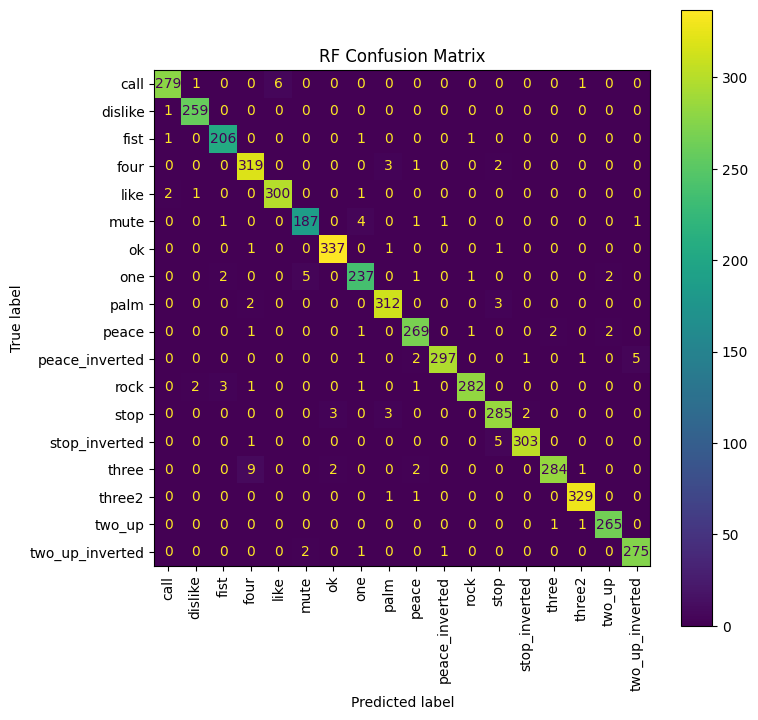

In [ ]:
cm_rf = confusion_matrix(y_test, y_pred_rf)
fig, ax = plt.subplots(figsize=(8,8))

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm_rf,
    display_labels=rf.classes_
)

disp.plot(ax=ax)

plt.xticks(rotation=90)

plt.title("RF Confusion Matrix")
plt.show()

In [ ]:
# Classification Report
report = classification_report(y_test, y_pred_rf)

print("Classification Report:\n", report)

Classification Report:
                  precision    recall  f1-score   support

           call       0.99      0.97      0.98       287
        dislike       0.98      1.00      0.99       260
           fist       0.97      0.99      0.98       209
           four       0.96      0.98      0.97       325
           like       0.98      0.99      0.98       304
           mute       0.96      0.96      0.96       195
             ok       0.99      0.99      0.99       340
            one       0.96      0.96      0.96       248
           palm       0.97      0.98      0.98       317
          peace       0.97      0.97      0.97       276
 peace_inverted       0.99      0.97      0.98       307
           rock       0.99      0.97      0.98       290
           stop       0.96      0.97      0.97       293
  stop_inverted       0.99      0.98      0.99       309
          three       0.99      0.95      0.97       298
         three2       0.99      0.99      0.99       331
      

## AdaBoostClassifier Using DecisionTree Model

## Fitting Date

In [16]:
base_model=DecisionTreeClassifier(max_depth=11, random_state=42)
adb = AdaBoostClassifier(estimator=base_model,learning_rate=0.5,n_estimators=600)
cv_scores = cross_val_score(adb,X_train,y_train,cv=3,scoring='f1_macro')

#Scores of cross validation
print("Cross Validation Scores:", cv_scores)

#mean score of the 3 folds = score of the svm model
print("Mean CV Score:", np.mean(cv_scores))



Cross Validation Scores: [0.98218873 0.98184111 0.98300578]
Mean CV Score: 0.9823452069101907


In [17]:
#fit model on whole data
adb.fit(X_train, y_train)

#predict the performane of the model
y_pred_adb = adb.predict(X_test)

#calculte f1 score on test split
f1 = f1_score(y_test, y_pred_adb,average='macro')
print("Test F1 Score:", f1)

Test F1 Score: 0.9815910397973183


In [18]:
# Save model to file
joblib.dump(adb, "adb_model.pkl")

print("Model saved successfully!")

Model saved successfully!


## Metrics

In [ ]:
acc = accuracy_score(y_test, y_pred_adb)
prec = precision_score(y_test, y_pred_adb, average='macro')
rec = recall_score(y_test, y_pred_adb, average='macro')
f1 = f1_score(y_test, y_pred_adb, average='macro')

print("\nADB Results:")
print(f"Accuracy  : {acc:.4f}")
print(f"Precision : {prec:.4f}")
print(f"Recall    : {rec:.4f}")
print(f"F1 Score  : {f1:.4f}")


ADB Results:
Accuracy  : 0.9821
Precision : 0.9816
Recall    : 0.9817
F1 Score  : 0.9816


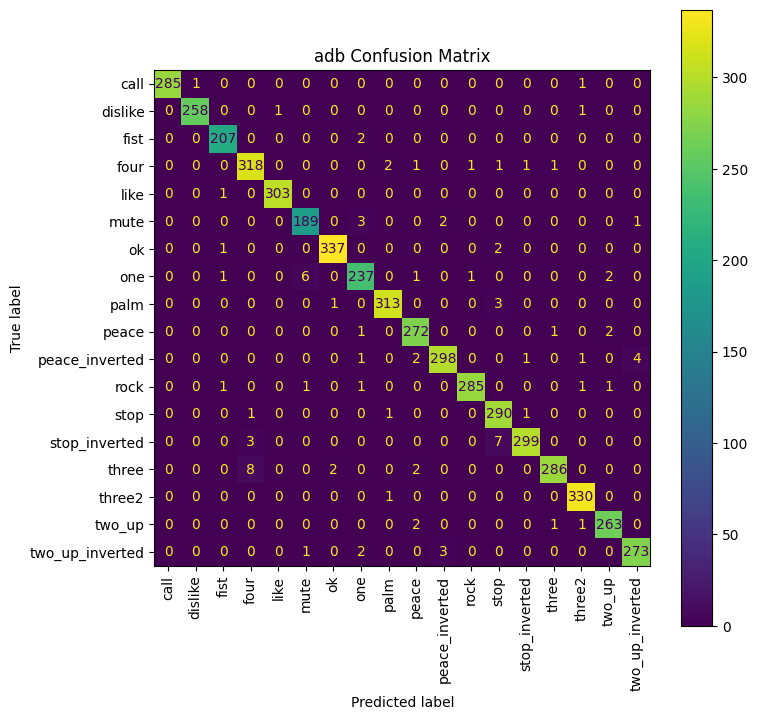

In [ ]:
cm_adb = confusion_matrix(y_test, y_pred_adb)
fig, ax = plt.subplots(figsize=(8,8))

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm_adb,
    display_labels=adb.classes_
)

disp.plot(ax=ax)

plt.xticks(rotation=90)

plt.title("adb Confusion Matrix")
plt.show()

In [ ]:
# Classification Report
report = classification_report(y_test, y_pred_adb)

print("Classification Report:\n", report)

Classification Report:
                  precision    recall  f1-score   support

           call       1.00      0.99      1.00       287
        dislike       1.00      0.99      0.99       260
           fist       0.98      0.99      0.99       209
           four       0.96      0.98      0.97       325
           like       1.00      1.00      1.00       304
           mute       0.96      0.97      0.96       195
             ok       0.99      0.99      0.99       340
            one       0.96      0.96      0.96       248
           palm       0.99      0.99      0.99       317
          peace       0.97      0.99      0.98       276
 peace_inverted       0.98      0.97      0.98       307
           rock       0.99      0.98      0.99       290
           stop       0.96      0.99      0.97       293
  stop_inverted       0.99      0.97      0.98       309
          three       0.99      0.96      0.97       298
         three2       0.99      1.00      0.99       331
      

## Conclusion

| Model | Accuracy | Precision | Recall | F1-Score |
|:------|:---------|:----------|:-------|:---------|
| KNN   | 0.9433   | 0.9443    | 0.9439 | 0.9439   |
| SVM   | 0.9786   | 0.9781    | 0.9781 | 0.9780   |
| RF    | 0.9786   | 0.9781    | 0.9781 | 0.9780   |
| Adb   | 0.9827   | 0.9820    | 0.9823 | 0.9821   |


Based on the F1-Score, the **AdaBoostClassifier (Adb)** model demonstrated the superior performance with an F1-Score of 0.9821. This indicates that AdaBoost was most effective in correctly classifying the diverse hand gestures after the applied preprocessing steps, closely followed by the SVM and Random Forest models.

## Generating output video using MediaPipe from an input one

In [ ]:
import mediapipe as mp
import cv2
import numpy as np
import joblib
from collections import Counter

# Load my 4 models
knn = joblib.load(r"KNN_model.pkl")
svm = joblib.load(r"svm_model.pkl")
adb = joblib.load(r"adb_model.pkl")
rf  = joblib.load(r"random_forest_model.pkl")

models  = [knn, svm, adb, rf]
weights = [1, 1, 1, 1]

# MediaPipe setup
mp_hands = mp.solutions.hands
hands = mp_hands.Hands(
    max_num_hands=1,
    model_complexity=0,
    min_detection_confidence=0.7,
    min_tracking_confidence=0.7
)
mp_draw = mp.solutions.drawing_utils

# Video I/O setup
INPUT_VIDEO  = r"Hand-Gesture.mp4"
OUTPUT_VIDEO = "output.mp4"

cap = cv2.VideoCapture(INPUT_VIDEO)

frame_width  = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps          = int(cap.get(cv2.CAP_PROP_FPS))

fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out    = cv2.VideoWriter(OUTPUT_VIDEO, fourcc, fps, (frame_width, frame_height))

def preprocess(landmarks):
    points = np.array([[lm.x, lm.y, lm.z] for lm in landmarks])

    x1, y1 = points[0, 0], points[0, 1]
    points[:, 0] -= x1
    points[:, 1] -= y1

    x13, y13 = points[12, 0], points[12, 1]
    norm = np.sqrt(x13**2 + y13**2)

    if norm > 0:
        points[:, 0] /= norm
        points[:, 1] /= norm

    return points.flatten()

def weighted_vote(models, weights, features):
    """Each model votes, weight is added to its predicted label. Majority wins."""
    vote_scores = Counter()
    for model, weight in zip(models, weights):
        prediction = model.predict([features])[0]
        vote_scores[prediction] += weight
    return vote_scores.most_common(1)[0][0]

# Processing state
frame_count       = 0
prediction_buffer = []
display_label     = ""

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    frame_count += 1

    rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    results   = hands.process(rgb_frame)

    # Predict on every frame
    if results.multi_hand_landmarks:
        for hand_landmarks in results.multi_hand_landmarks:
            mp_draw.draw_landmarks(frame, hand_landmarks, mp_hands.HAND_CONNECTIONS)

            features   = preprocess(hand_landmarks.landmark)
            prediction = weighted_vote(models, weights, features)

            prediction_buffer.append(prediction)

    # Every 5 frames: take majority from buffer
    if frame_count % 5 == 0:
        if prediction_buffer:
            majority      = Counter(prediction_buffer).most_common(1)[0][0]
            display_label = majority
        prediction_buffer = []

    # Draw label on frame (top left)
    if display_label:
        cv2.putText(
            frame, f"Gesture: {display_label}",
            (10, 50),
            cv2.FONT_HERSHEY_SIMPLEX,
            1.5, (0, 255, 0), 3, cv2.LINE_AA
        )

    out.write(frame)

cap.release()
out.release()
cv2.destroyAllWindows()
print(f"Done! Output saved to: {OUTPUT_VIDEO}")

C:\Users\karim\AppData\Roaming\Python\Python310\site-packages\sklearn\base.py:442: InconsistentVersionWarning: Trying to unpickle estimator KNeighborsClassifier from version 1.8.0 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
C:\Users\karim\AppData\Roaming\Python\Python310\site-packages\sklearn\base.py:442: InconsistentVersionWarning: Trying to unpickle estimator SVC from version 1.8.0 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
C:\Users\karim\AppData\Roaming\Python\Python310\site-packages\sklearn\base.py:442: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version

Done! Output saved to: output1.mp4


## For using a Webcam

In [ ]:
import mediapipe as mp
import cv2
import joblib
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score


# Load my 4 models
knn = joblib.load(r"KNN_model.pkl")
svm = joblib.load(r"svm_model.pkl")
adb = joblib.load(r"adb_model.pkl")
rf  = joblib.load(r"random_forest_model.pkl")

models = [knn, svm, adb, rf]
weights = [1, 1, 1, 1]

# MediaPipe setup
mp_hands = mp.solutions.hands
hands = mp_hands.Hands(max_num_hands=1, min_detection_confidence=0.7)
mp_draw = mp.solutions.drawing_utils

# Webcam feeding
cap = cv2.VideoCapture(0)

print("Starting Webcam. Press 'q' to exit.")

while cap.isOpened():
    ret, frame = cap.read()
    if not ret: break

    frame = cv2.flip(frame, 1)
    rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    results = hands.process(rgb_frame)

    if results.multi_hand_landmarks:
        for hand_landmarks in results.multi_hand_landmarks:
            mp_draw.draw_landmarks(frame, hand_landmarks, mp_hands.HAND_CONNECTIONS)
            coords = np.array([[lm.x, lm.y, lm.z] for lm in hand_landmarks.landmark])
            coords = coords - coords[0]
            dist = np.linalg.norm(coords[12] - coords[0])
            if dist > 0: coords = coords / dist
            features = coords.flatten().reshape(1, -1)
            votes = []
            for model in models:
                votes.append(model.predict(features)[0])
            
            from collections import Counter
            prediction = Counter(votes).most_common(1)[0][0]
            cv2.putText(frame, f"Gesture: {prediction}", (10, 50), 
                        cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

    cv2.imshow("Hand Gesture Recognition", frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

### Insight: The notebook sets up a webcam feed using MediaPipe to detect hand landmarks in real-time

### The landmarks are preprocessed by centering them around the wrist and scaling them based on the distance between the wrist and the middle finger tip before being passed to the models for prediction

### A simple majority vote is used to determine the final predicted gesture from the four models